In [39]:
import sys
sys.path.append('../../code')

In [40]:
import convml_tt
import convml_tt.utils
from convml_tt.architectures.triplet_trainer import TileType
from convml_tt.data.triplets import load_tile_definitions
from convml_tt.data.sources import satdata

from pathlib import Path
import matplotlib.pyplot as plt

import xarray as xr
import seaborn as sns

In [41]:
import shapely.geometry as geom
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from pathlib import Path
import yaml

In [42]:
#from convective_organisation.data.processing import goes16_oldcomp_500
#from convective_organisation.data.sources.satdata.bbox import LatLonBox
#from convective_organisation.data.sources.satdata import processing
#from convective_organisation.data.sources import satdata

In [43]:
data_path = Path('../../data/storage')

In [44]:
tileset_path = data_path/"tiles"/"goes16"/"Nx256_s200000.0_N1000study_N10000train"
tile_path = tileset_path/"train"

In [45]:
triplets = convml_tt.NPMultiImageList.from_folder(tile_path)

(None, None, None)

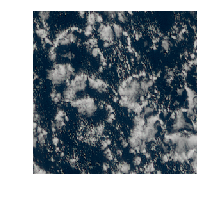

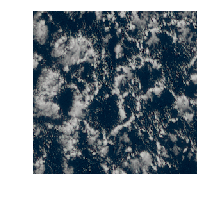

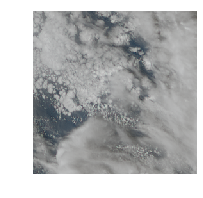

In [262]:
#### 
m = 194
triplets[m][0].show(), triplets[m][1].show(), triplets[m][2].show()

In [263]:
import convml_tt.interpretation.tile_aggregation

In [264]:
tiles = list(zip(*[
    load_tile_definitions(triplets[m:m+1], tile_type=tile_type)
    for tile_type in [TileType.ANCHOR, TileType.NEIGHBOR, TileType.DISTANT]
]))[0]

100%|██████████| 1/1 [00:00<00:00,  9.14it/s]


In [265]:
tiles

(<convml_tt.data.triplets.TripletTile at 0x7f1130c5b8d0>,
 <convml_tt.data.triplets.TripletTile at 0x7f1130a22240>)

In [266]:
tile_a, tile_n, tile_d = tiles

tile_a, tile_n = tile_n, tile_a

In [267]:
scene_fns = tile_a.meta['rgb_source_files']

In [268]:
TILING_BBOX_EXTENT = [
    (-60, 10), # (lon, lat) min
    (-30, 30) # (lon, lat) max
]

In [269]:
cli = satdata.Goes16AWS()
path_composites = data_path/"composites"
da_rgb_composite = satdata.processing.load_data_for_rgb([scene_fns, ], cli=cli, path_composites=path_composites,
                                                bbox_extent=TILING_BBOX_EXTENT,
                                                use_old=False)[0]

  0%|          | 0/1 [00:00<?, ?it/s]/nfs/see-fs-02_users/earlcd/datastore/a289/anaconda2/envs/fastai2/lib/python3.7/site-packages/xarray/conventions.py:394: SerializationWarning: variable 'concatenate-0270b95559e273eec3f269d9cecad817' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  stack_char_dim=stack_char_dim)
100%|██████████| 1/1 [00:00<00:00,  7.10it/s]

Creating composites in domain bounding box


In [270]:
scene_fns = tile_d.meta['rgb_source_files']

da_rgb_composite_dist = satdata.processing.load_data_for_rgb([scene_fns, ], cli=cli, path_composites=path_composites,
                                                bbox_extent=TILING_BBOX_EXTENT,
                                                use_old=False)[0]

  0%|          | 0/1 [00:00<?, ?it/s]/nfs/see-fs-02_users/earlcd/datastore/a289/anaconda2/envs/fastai2/lib/python3.7/site-packages/xarray/conventions.py:394: SerializationWarning: variable 'concatenate-4f9735f1de6c687f8279872dea68a96c' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  stack_char_dim=stack_char_dim)
100%|██████████| 1/1 [00:00<00:00,  8.99it/s]

Creating composites in domain bounding box


In [271]:
from convml_tt.data.sources.satdata.bbox import LatLonBox
from convml_tt.data.sources.satdata.satpy_rgb import rgb_da_to_img

tiling_bbox = LatLonBox(TILING_BBOX_EXTENT)

In [274]:
bbox_shape = tiling_bbox.get_outline_shape()

s = 5
img_rgb = rgb_da_to_img(da_rgb_composite.isel(x=slice(None, None, s), y=slice(None, None, s)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


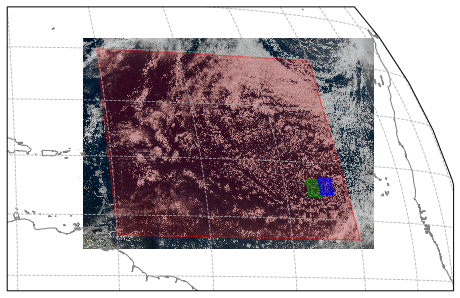

In [275]:
fig = plt.figure(figsize=(8, 6))
#projection = ccrs.Geostationary(central_longitude=-60) # too costly when we're showing the composite
projection = da_rgb_composite.crs
ax = plt.subplot(projection=projection)

#da_rgb_composite.sel(bands='R').isel(x=slice(None, None, 100), y=slice(None, None, 100)).plot(
#ax=ax, transform=da_rgb_composite.crs, rasterized=True
#)
#da_rgb_composite.sel(bands='R').plot(ax=ax, transform=da_rgb_composite.crs, rasterized=True)

img_rgb.data.plot.imshow(
    ax=ax, transform=da_rgb_composite.crs, rasterized=True, rgb='bands'
)

gl = ax.gridlines(linestyle='--', draw_labels=False)
ax.coastlines(resolution='10m', color='grey')

def draw_box(geom, color, face_alpha=0.5):

    ax.add_geometries([geom,], crs=ccrs.PlateCarree(), alpha=face_alpha,
              edgecolor=color, facecolor=color)
    ax.add_geometries([geom,], crs=ccrs.PlateCarree(), alpha=face_alpha*2.0,
              edgecolor=color, facecolor='none', linewidth=1.0)
    
draw_box(bbox_shape, color='red', face_alpha=0.2)
draw_box(tile_a.get_outline_shape(), color='green')
draw_box(tile_n.get_outline_shape(), color='blue')

ax.set_extent([-70, -10, 5, 35], crs=ccrs.PlateCarree())  # [x0, x1, y0, y1]

plt.savefig('domain_overview_triplets.pdf')

In [276]:
rgb_tile_a = tile_a.crop_field(da_rgb_composite)

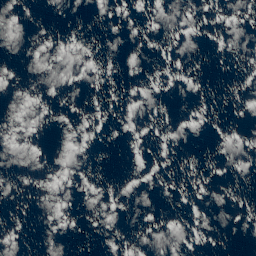

In [277]:
tile_a.create_true_color_img(da_rgb_composite, resampling_N=256)

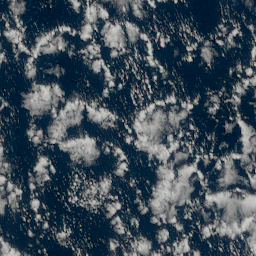

In [278]:
tile_n.create_true_color_img(da_rgb_composite, resampling_N=256)

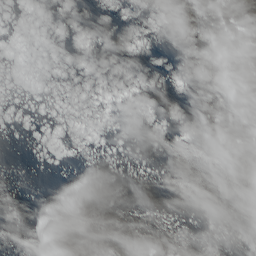

In [279]:
tile_d.create_true_color_img(da_rgb_composite_dist, resampling_N=256)